In [1]:
import math
import torch

weights = torch.randn(256, 4) / math.sqrt(256) 
# print(weights.shape)

## 256x4 행렬의 숫자가 경사 역전파를 통해 조정될 수 있게 만든다.
weights.requires_grad_()

## 편향값 훈련 가능하게 설정
bias = torch.zeros(4, requires_grad=True)

In [2]:
## 여기서 부터 실습

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [4]:
class ConvNet(nn.Module) : 
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1) ## 입력 1채널, 출력 16채널, 커널 3, 스트라이드 1
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 = 12x12x32
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op
        

In [17]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) ##Negative Log Likelihood 
        loss.backward()
        optim.step() ##최적화 과정
        if b_i % 10 == 0 :
            print('epoch: {} [{}/{} ({:.0f}%)] \t training loss : {:.6f}'.format(epoch, b_i, len(train_dataloader), b_i / len(train_dataloader)*100, loss.item()))
        

In [6]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()
            
            ##가장 킹능성이 높은 예측을 얻기 위해 argmax 사용함
            pred = pred_prob.argmax(dim=1, keepdim=True)
            
            success += pred.eq(y.view_as(pred)).sum().item()
        
        loss /= len(test_dataloader.dataset)
        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:0f}%)\n'.format(loss, success, len(test_dataloader.dataset), 100. * success / len(test_dataloader.dataset)))
        

In [11]:
train_dataloader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), \
                                                                                                                               transforms.Normalize((0.1302,), (0.3069))])),\
                                             batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform = transforms.Compose([transforms.ToTensor(),\
                                                                                                                   transforms.Normalize((0.1302,), (0.3069,))\
                                                                                                                   ])),\
                                             batch_size=500, shuffle=False)

In [12]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr = 0.5)

In [18]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/1875 (0%)] 	 training loss : 0.163313
epoch: 1 [10/1875 (1%)] 	 training loss : 0.137107
epoch: 1 [20/1875 (1%)] 	 training loss : 0.064922
epoch: 1 [30/1875 (2%)] 	 training loss : 0.027744
epoch: 1 [40/1875 (2%)] 	 training loss : 0.180184
epoch: 1 [50/1875 (3%)] 	 training loss : 0.017911
epoch: 1 [60/1875 (3%)] 	 training loss : 0.002331
epoch: 1 [70/1875 (4%)] 	 training loss : 0.077977
epoch: 1 [80/1875 (4%)] 	 training loss : 0.008578
epoch: 1 [90/1875 (5%)] 	 training loss : 0.045218
epoch: 1 [100/1875 (5%)] 	 training loss : 0.040113
epoch: 1 [110/1875 (6%)] 	 training loss : 0.049325
epoch: 1 [120/1875 (6%)] 	 training loss : 0.048317
epoch: 1 [130/1875 (7%)] 	 training loss : 0.188791
epoch: 1 [140/1875 (7%)] 	 training loss : 0.011541
epoch: 1 [150/1875 (8%)] 	 training loss : 0.069988
epoch: 1 [160/1875 (9%)] 	 training loss : 0.031489
epoch: 1 [170/1875 (9%)] 	 training loss : 0.021596
epoch: 1 [180/1875 (10%)] 	 training loss : 0.045939
epoch: 1 [190/1875 (10

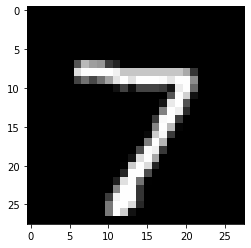

In [20]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')

In [21]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"graound truth is : {sample_targets[0]}")

Model prediction is : 7
graound truth is : 7


c:\Users\handy\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
